<a href="https://colab.research.google.com/github/Ganasa18/belajar-tensorflow/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow


## Get the data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/datasets/dansbecker/food-101/data


However we've modified it to only use two classes (pizza & steak)

**Note:** We start with a smaller dataset so we can experiement quickly and figure what works (or better yet what doesn't work) before scalling up

In [ ]:
# import wget
# import zipfile
# url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip'
# downloaded_file = wget.download(url)

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip")
# zip_ref.extractall()
# zip_ref.close()


## Inpsect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data And for a computer vision project this usually means visualizing many samples of your data

In [ ]:
!ls pizza_steak

test
train


In [ ]:
import os

# Walk thorugh pizza_steak directory

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 0 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [ ]:
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize oyr images, first let's get the class names programmatically.

In [ ]:
# Get the classnames programmitically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
# class_names = class_names[1:] #remove .DS_store if exist
print(class_names)

['pizza' 'steak']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['234626.jpg']
Image shape: (512, 384, 3)


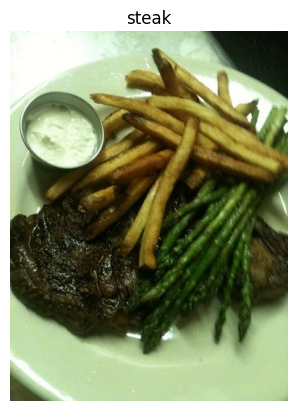

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [ ]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[234, 252, 230],
        [236, 254, 232],
        [236, 255, 233],
        ...,
        [  4,  14,   6],
        [  4,  14,   6],
        [  4,  14,   6]],

       [[237, 255, 233],
        [236, 254, 232],
        [234, 253, 231],
        ...,
        [  4,  14,   6],
        [  4,  14,   6],
        [  4,  14,   6]],

       [[237, 255, 234],
        [235, 254, 232],
        [232, 251, 229],
        ...,
        [  4,  14,   6],
        [  3,  13,   5],
        [  3,  13,   5]],

       ...,

       [[ 72,  81,  50],
        [ 70,  79,  48],
        [ 69,  78,  47],
        ...,
        [157, 181, 129],
        [153, 178, 123],
        [149, 174, 117]],

       [[ 70,  80,  46],
        [ 70,  80,  46],
        [ 69,  80,  48],
        ...,
        [150, 173, 121],
        [145, 168, 114],
        [141, 164, 108]],

       [[ 64,  74,  40],
        [ 65,  75,  41],
        [ 67,  78,  46],
        ...,
        [140, 163, 11

In [ ]:
img.shape # returns width, height, colour channels

(512, 384, 3)

**Note:** one of the most common preprocessing steps working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value).

In [ ]:
# Get all the pixel values between 0 & 1
img/255.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## end-to-end example

Let's build a convulitional neural network to find pattern in our images, more specifically:

* Load our images
* Preproccess our images
* Build a CNN to find patterns in our images\
* Compile our CNN
* Fit hte CNN to our training data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)), #because reshape to 224 x 224
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
# not need to create labels because flow_from_directory instead created label
history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 5s 90ms/step - loss: 0.6415 - accuracy: 0.6240 - val_loss: 0.5200 - val_accuracy: 0.7520
Epoch 2/5
47/47 [==============================] - 4s 80ms/step - loss: 0.5249 - accuracy: 0.7587 - val_loss: 0.4638 - val_accuracy: 0.8100
Epoch 3/5
47/47 [==============================] - 4s 79ms/step - loss: 0.4630 - accuracy: 0.7827 - val_loss: 0.3818 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 4s 75ms/step - loss: 0.4161 - accuracy: 0.8207 - val_loss: 0.3579 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 4s 79ms/step - loss: 0.3737 - accuracy: 0.8447 - val_loss: 0.3349 - val_accuracy: 0.8460


**Note:** If the above cell taking longer than  ~10 seconds per epoch, make sure you're using a GPU

In [ ]:
len(train_data)

47

In [ ]:
1500/32

46.875

In [ ]:
# Epoch 1/5 with CPU
# 47/47 [==============================] - 116s 2s/step - loss: 0.5671 - accuracy: 0.6840 - val_loss: 0.3925 - val_accuracy: 0.8320

In [ ]:
# Get a model summary
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_28 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_30 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

## Using the same model as before

Let's replicate the model we've built in a previous section to see ot wprl wotj our image data The model we're building is from the [TensorFlow Playground environment](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

In [ ]:
train_data

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 4s 84ms/step - loss: 0.7960 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 4s 78ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 4s 78ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 4s 80ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 4s 76ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [ ]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 150528)            0         
                                                                 
 dense_23 (Dense)            (None, 4)                 602116    
                                                                 
 dense_24 (Dense)            (None, 4)                 20        
                                                                 
 dense_25 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more parameters than our CNN (model_1), model_2 performs terribly.. let's try improve

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as above vbut let's step up a notch)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 4s 75ms/step - loss: 4.5624 - accuracy: 0.6413 - val_loss: 0.9834 - val_accuracy: 0.5960
Epoch 2/5
47/47 [==============================] - 3s 72ms/step - loss: 1.2181 - accuracy: 0.6973 - val_loss: 0.6702 - val_accuracy: 0.7280
Epoch 3/5
47/47 [==============================] - 3s 71ms/step - loss: 1.0862 - accuracy: 0.7180 - val_loss: 0.9456 - val_accuracy: 0.6440
Epoch 4/5
47/47 [==============================] - 4s 74ms/step - loss: 0.7887 - accuracy: 0.7427 - val_loss: 0.7194 - val_accuracy: 0.7220
Epoch 5/5
47/47 [==============================] - 4s 80ms/step - loss: 0.5593 - accuracy: 0.7753 - val_loss: 0.9638 - val_accuracy: 0.6260


In [ ]:
# Get Summary
model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 150528)            0         
                                                                 
 dense_26 (Dense)            (None, 100)               15052900  
                                                                 
 dense_27 (Dense)            (None, 100)               10100     
                                                                 
 dense_28 (Dense)            (None, 100)               10100     
                                                                 
 dense_29 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


## Bianary Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scaling/ normalizing)
3. Created a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and imporve the model (try to beat our baseline)
7. Repeat untils satisfied (experiment, experiment, experiment)

### 1. Become one with the data

['1081258.jpg']
Image shape: (384, 512, 3)
['299535.jpg']
Image shape: (382, 512, 3)


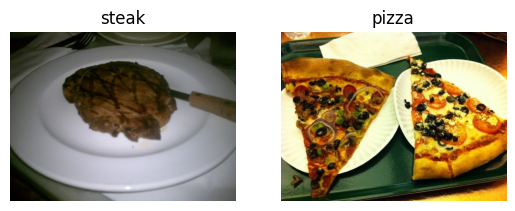

In [ ]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocessing the data (prepare it forn a model)

In [ ]:
# Define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:
1. 10,000 images (or more) miight not fit into the memory of your processor (GPU).

2. Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to laern very well.

Why 32?
Because 32 good for your health



In [ ]:
!nvidia-smi

Mon Apr 15 01:29:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5             14W /   60W |    4904MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of the training data batch
images, labels = train_data.next() #get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
# Get the first tow images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [ ]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

## 3. Create a model (start with a baseline)

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu',
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

## 4. Fit the model

In [ ]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [ ]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 5s 89ms/step - loss: 0.7072 - accuracy: 0.6907 - val_loss: 0.4407 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 4s 89ms/step - loss: 0.4304 - accuracy: 0.8113 - val_loss: 0.4387 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 4s 90ms/step - loss: 0.3311 - accuracy: 0.8653 - val_loss: 0.3773 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 4s 81ms/step - loss: 0.1936 - accuracy: 0.9280 - val_loss: 0.3719 - val_accuracy: 0.8340
Epoch 5/5
47/47 [==============================] - 4s 81ms/step - loss: 0.0748 - accuracy: 0.9773 - val_loss: 0.4246 - val_accuracy: 0.8380


## 5.Evaluating our model

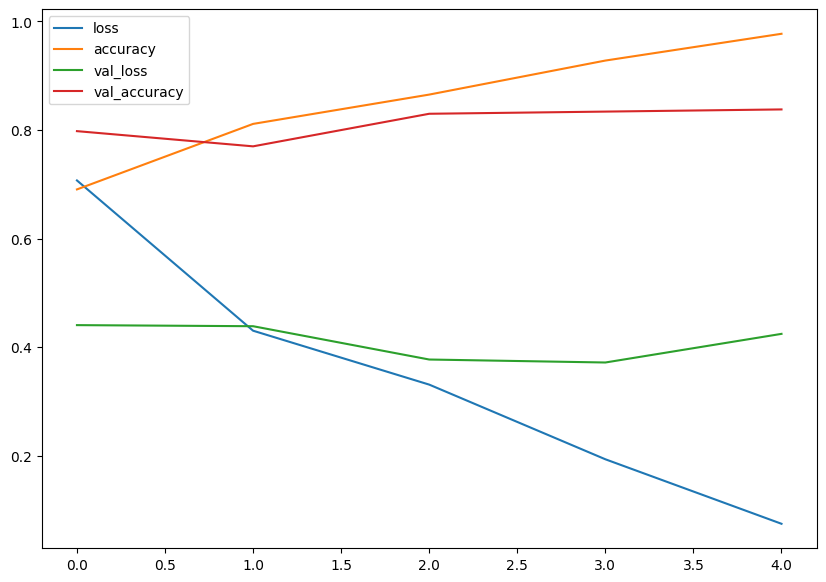

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

In [ ]:
model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_32 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_33 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_15 (Flatten)        (None, 475240)            0         
                                                                 
 dense_30 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.evaluate(test_data)

16/16 [==============================] - 1s 56ms/step - loss: 0.4246 - accuracy: 0.8380


[0.4246026277542114, 0.8379999995231628]

In [ ]:
model_1.evaluate(test_data)

16/16 [==============================] - 1s 60ms/step - loss: 0.3349 - accuracy: 0.8460


[0.33494096994400024, 0.8460000157356262]

In [ ]:
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_28 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_30 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

In [ ]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation matrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"])) # how many epochs did we run for ?

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

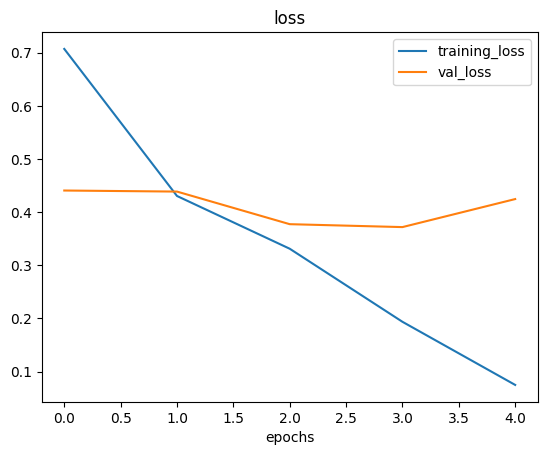

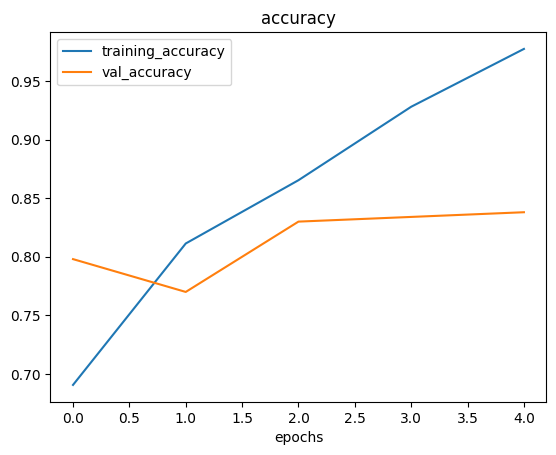

In [ ]:
# Check out the loss and accuracy
plot_loss_curves(history_4)

🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's **overfitting** the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished.

## 6. Adjust the model parameters
Fitting a machine learning model comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.
So far we've gone through steps 0 and 1.

Ways to induce overfitting:

*   Increase the number of convolutional layers.
*   Increase the number of convolutional filters.
*   Add another dense layer to the output of our flattened layer.

Reduce overfitting:
* Add data augmentatation
* Add regularization layers (such as MaxPoll2d)
* Add more data...



In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [ ]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 5s 88ms/step - loss: 0.6069 - accuracy: 0.6707 - val_loss: 0.4869 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 4s 83ms/step - loss: 0.4554 - accuracy: 0.7907 - val_loss: 0.3836 - val_accuracy: 0.8260
Epoch 3/5
47/47 [==============================] - 4s 82ms/step - loss: 0.4214 - accuracy: 0.8140 - val_loss: 0.3731 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 4s 83ms/step - loss: 0.3896 - accuracy: 0.8340 - val_loss: 0.3381 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 4s 81ms/step - loss: 0.3764 - accuracy: 0.8427 - val_loss: 0.3071 - val_accuracy: 0.8780


In [ ]:
# Get a summary
model_5.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 26, 26, 10)     

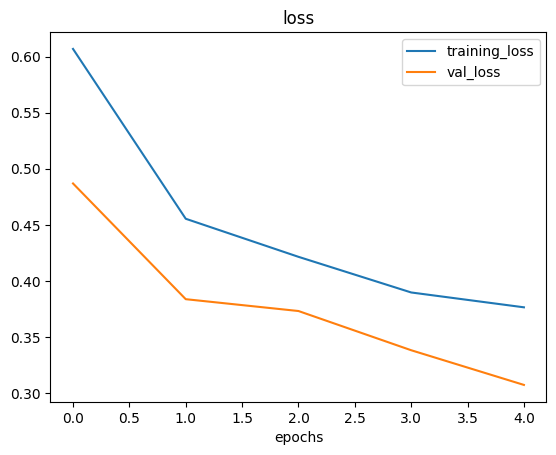

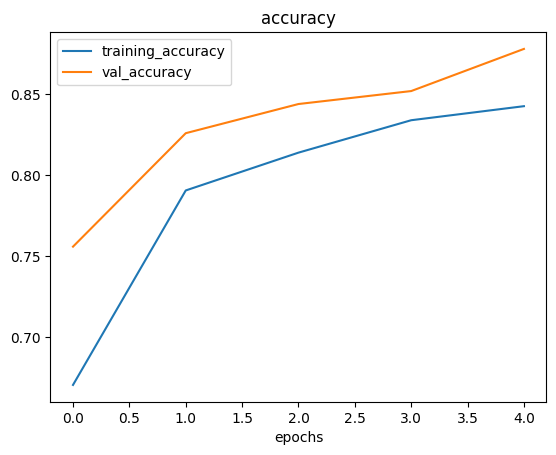

In [ ]:
# Plot loss curves
plot_loss_curves(history_5)

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

**Question:** What's data augmentation?

Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

IMG_SIZE = (224, 224)
# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

showing image numebr: 15


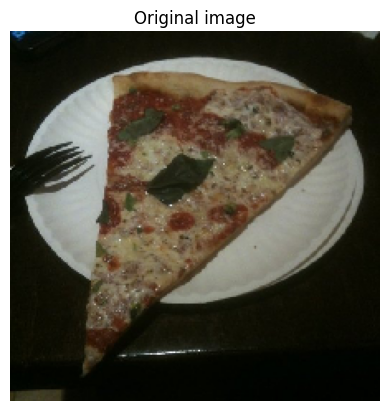

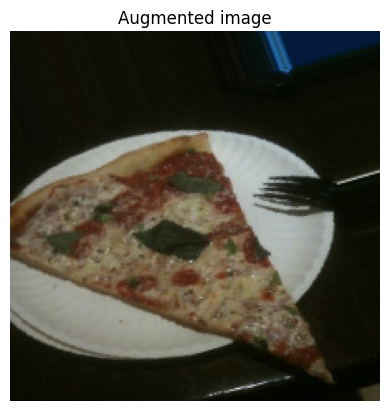

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
print(f"showing image numebr: {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 15s 315ms/step - loss: 0.7075 - accuracy: 0.4860 - val_loss: 0.6922 - val_accuracy: 0.5020
Epoch 2/5
47/47 [==============================] - 14s 294ms/step - loss: 0.6935 - accuracy: 0.4973 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 14s 287ms/step - loss: 0.6937 - accuracy: 0.5013 - val_loss: 0.6910 - val_accuracy: 0.5700
Epoch 4/5
47/47 [==============================] - 14s 290ms/step - loss: 0.6988 - accuracy: 0.5820 - val_loss: 0.6907 - val_accuracy: 0.5900
Epoch 5/5
47/47 [==============================] - 13s 280ms/step - loss: 0.6911 - accuracy: 0.5667 - val_loss: 0.6863 - val_accuracy: 0.5740


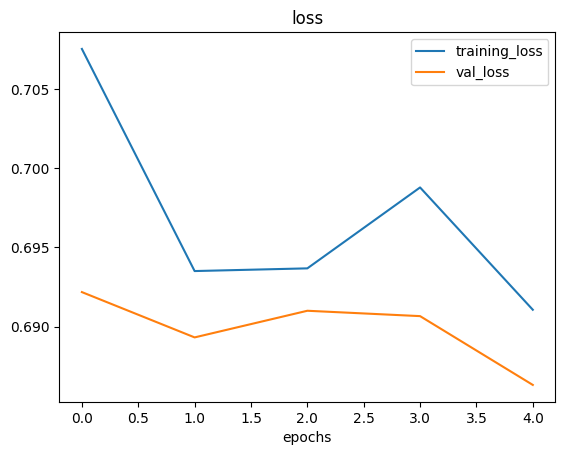

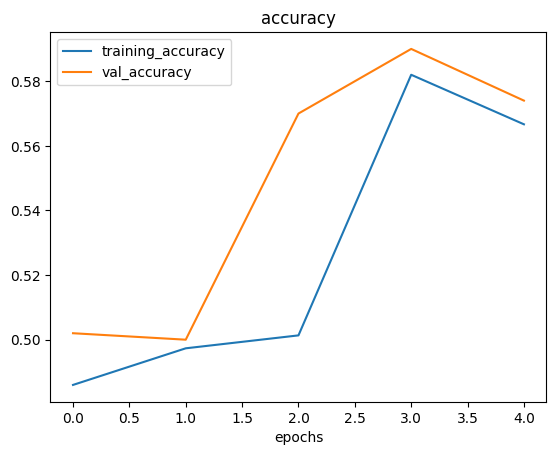

In [ ]:
# Plot loss curves
plot_loss_curves(history_6)

In [ ]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [ ]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 276ms/step - loss: 0.6356 - accuracy: 0.6367 - val_loss: 0.4638 - val_accuracy: 0.8080
Epoch 2/5
47/47 [==============================] - 13s 271ms/step - loss: 0.5601 - accuracy: 0.7187 - val_loss: 0.4378 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 13s 267ms/step - loss: 0.5347 - accuracy: 0.7320 - val_loss: 0.4175 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 13s 269ms/step - loss: 0.5233 - accuracy: 0.7540 - val_loss: 0.4686 - val_accuracy: 0.7900
Epoch 5/5
47/47 [==============================] - 13s 270ms/step - loss: 0.5018 - accuracy: 0.7767 - val_loss: 0.3737 - val_accuracy: 0.8460


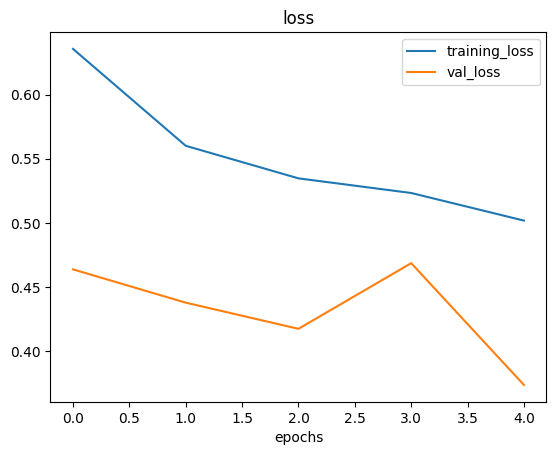

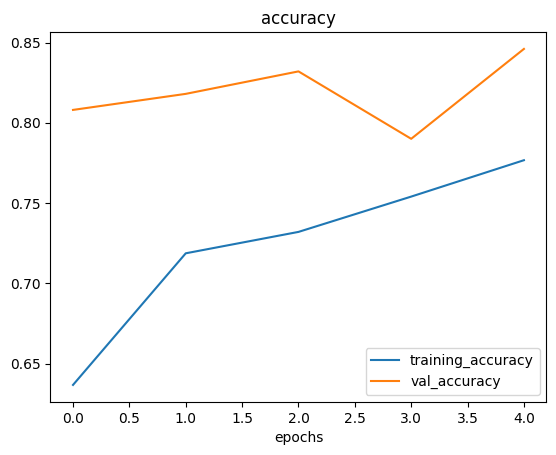

In [ ]:
plot_loss_curves(history_7)

## 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our mode

* Increase the number of model layers (e.g. add more convolutional layers)
*
Increase the number of filters in each convolutiona layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error)
*
Train for longe(more epochs)
* Finding an ideal learning rate
* Get more data (give the model more opportunities to learn)
* Use
**transfer learning** to leverage what another image model has learned and adjust it for our own use casecase.l:

## Making a prediction with our trained model on our own custom data

In [ ]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


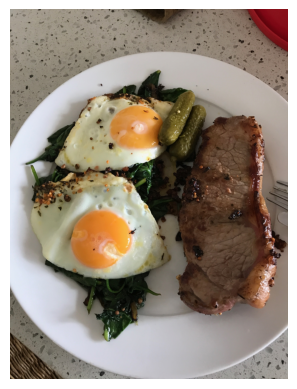

In [ ]:
# View our example image
import matplotlib.image as mpimg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
# Check the sape of our image
steak.shape, steak

((4032, 3024, 3),
 array([[[162, 158, 149],
         [163, 159, 150],
         [166, 162, 153],
         ...,
         [136,  17,  23],
         [140,  21,  27],
         [140,  21,  27]],
 
        [[164, 160, 151],
         [164, 160, 151],
         [164, 160, 151],
         ...,
         [133,  14,  20],
         [134,  15,  21],
         [137,  18,  24]],
 
        [[166, 162, 153],
         [165, 161, 152],
         [163, 159, 150],
         ...,
         [136,  17,  23],
         [134,  15,  21],
         [136,  17,  23]],
 
        ...,
 
        [[154, 132, 111],
         [142, 121, 100],
         [101,  80,  59],
         ...,
         [164, 155, 148],
         [152, 141, 135],
         [140, 129, 123]],
 
        [[141, 119,  96],
         [138, 118,  94],
         [106,  85,  64],
         ...,
         [158, 147, 141],
         [142, 131, 125],
         [138, 127, 121]],
 
        [[148, 126, 102],
         [148, 128, 103],
         [114,  93,  72],
         ...,
         [

In [ ]:
tf.expand_dims(steak, axis=0).shape
expanded_steak = tf.expand_dims(steak, axis=0)

> **Note:** When you a train a neural network and you want to make a prediction with it on your own custom data, it's important than your custom data (or new adata) is preprocessed into the same format as the data your model awaas trained on.

In [ ]:
# Create a function to import and image and resize it to be able to 224 x 224 be used with our model
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, truns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values betwwen 0 and 1)
    img = img/255.
    return img

In [ ]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (4032, 3024, 3)
Shape after new dimension: (1, 4032, 3024, 3)


<tf.Tensor: shape=(1, 4032, 3024, 3), dtype=uint8, numpy=
array([[[[162, 158, 149],
         [163, 159, 150],
         [166, 162, 153],
         ...,
         [136,  17,  23],
         [140,  21,  27],
         [140,  21,  27]],

        [[164, 160, 151],
         [164, 160, 151],
         [164, 160, 151],
         ...,
         [133,  14,  20],
         [134,  15,  21],
         [137,  18,  24]],

        [[166, 162, 153],
         [165, 161, 152],
         [163, 159, 150],
         ...,
         [136,  17,  23],
         [134,  15,  21],
         [136,  17,  23]],

        ...,

        [[154, 132, 111],
         [142, 121, 100],
         [101,  80,  59],
         ...,
         [164, 155, 148],
         [152, 141, 135],
         [140, 129, 123]],

        [[141, 119,  96],
         [138, 118,  94],
         [106,  85,  64],
         ...,
         [158, 147, 141],
         [142, 131, 125],
         [138, 127, 121]],

        [[148, 126, 102],
         [148, 128, 103],
         [114,  

In [ ]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
pred = model_7.predict(tf.expand_dims(steak, axis=0))
pred

1/1 [==============================] - 0s 55ms/step


array([[0.78482246]], dtype=float32)

Looks like our custom image is being put through our model,
however, it currently outputs a predict visualize the image as well as the model's prediction ?

In [ ]:
# Remind ourselve of our class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# We can index the predicted class by rounding the prediction probability and indexing it on the class
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model
    and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_pre_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predict class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 0s 19ms/step


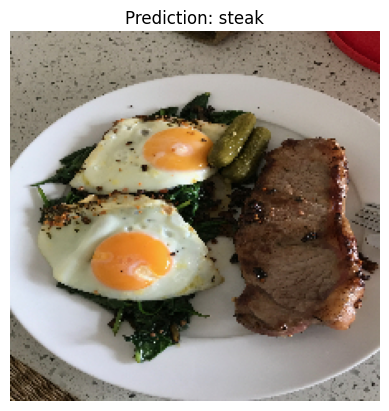

In [ ]:
# Test our model on a custom image
pred_and_plot(model_7, "03-steak.jpeg")

1/1 [==============================] - 0s 19ms/step


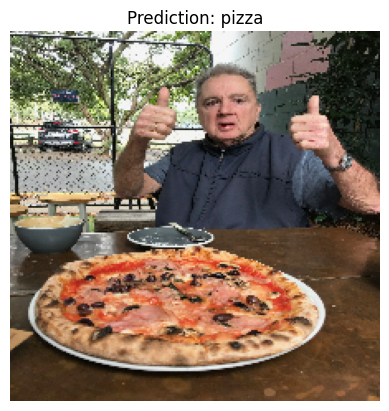

In [ ]:
pred_and_plot(model_7, "03-pizza-dad.jpeg")

In [ ]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 14s 285ms/step - loss: 0.6043 - accuracy: 0.6733 - val_loss: 0.4464 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 13s 280ms/step - loss: 0.5469 - accuracy: 0.7333 - val_loss: 0.3983 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 13s 273ms/step - loss: 0.4982 - accuracy: 0.7640 - val_loss: 0.4060 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 13s 273ms/step - loss: 0.4590 - accuracy: 0.8007 - val_loss: 0.3543 - val_accuracy: 0.8560
Epoch 5/5
47/47 [==============================] - 14s 289ms/step - loss: 0.4816 - accuracy: 0.7840 - val_loss: 0.3487 - val_accuracy: 0.8680


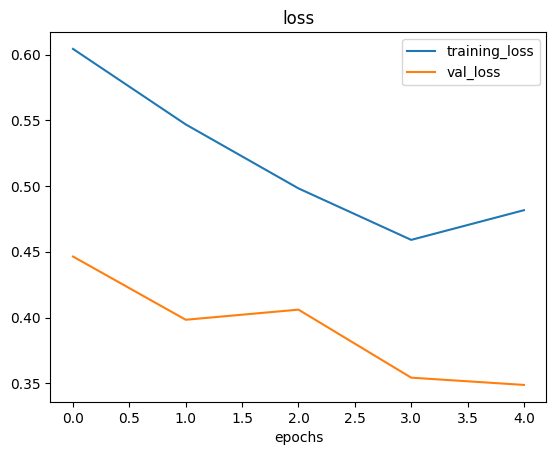

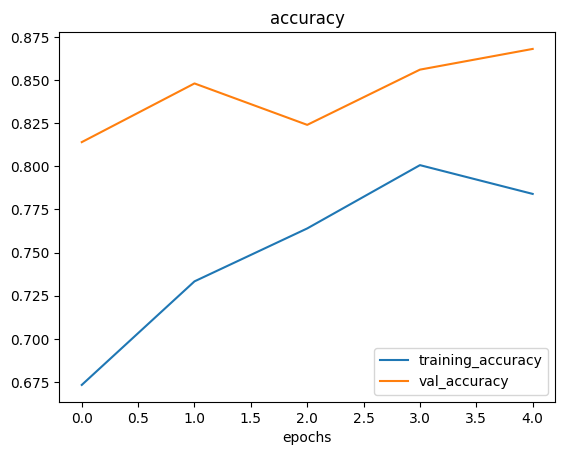

In [ ]:
plot_loss_curves(history_8)

In [ ]:
# Check model_1 architecture (same as model_8)
model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_28 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_30 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

In [ ]:
# Check model_8 architecture (same as model_1)
model_8.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_44 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_46 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

1/1 [==============================] - 0s 59ms/step


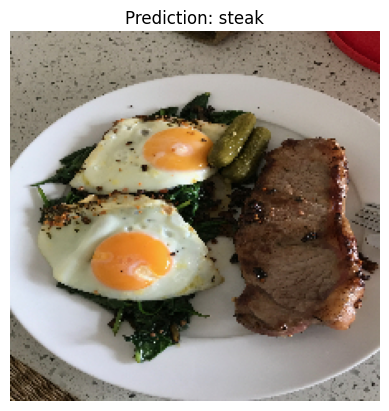

In [ ]:
pred_and_plot(model_8, "03-steak.jpeg")

1/1 [==============================] - 0s 20ms/step


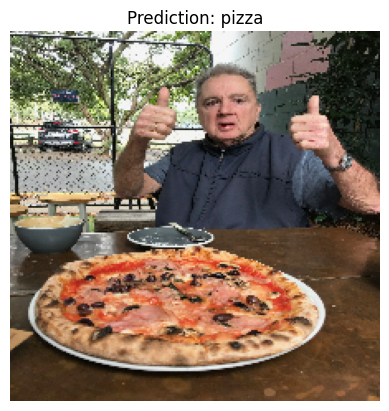

In [ ]:
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)

1/1 [==============================] - 0s 23ms/step


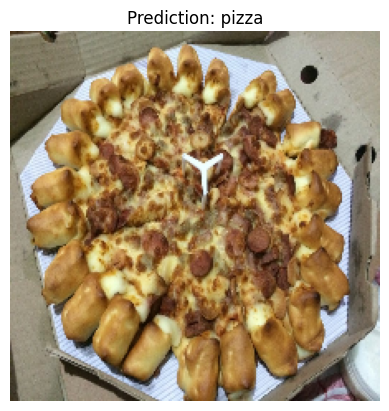

In [ ]:
pred_and_plot(model_8, "pizza-hut.jpeg", class_names)

1/1 [==============================] - 0s 27ms/step


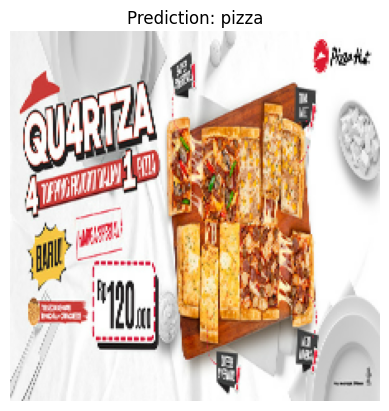

In [ ]:
pred_and_plot(model_8, "pizza-limo.jpg", class_names)

1/1 [==============================] - 0s 32ms/step


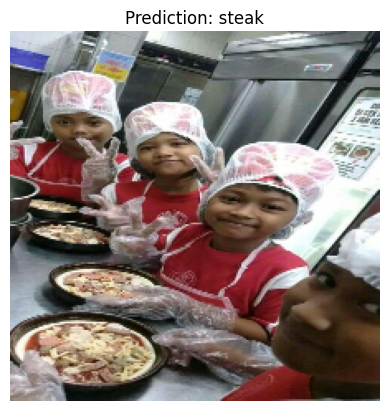

In [ ]:
pred_and_plot(model_8, "pizza-making.jpeg", class_names) # failed to predict pizza